<a href="https://colab.research.google.com/github/allen-del/Learning_PyTorch/blob/main/02.%20Binary%20and%20Multiclass%20Classification%20using%20Neural%20Networks%20/%2002neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network Classification with PyTorch

We give some data(images, text etc.) converted to a tensor as input and get an output tensor (of size number of classes). The output tensor contains probabilities that the particular sample belongs to one of the classes.  

Common types are:

* Binary Classification - two classes only (eg. Looking at medical data and predicting Cancer or No Cancer)
* Multiclass classification - more than two classes (eg. is that an image of a dog, cat, fish, human)
* Multilabel Classification - more than one label for a particular sample

##Make Classification data and get it ready

In [2]:
import sklearn

from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

#Create circles using a toy dataset from sklearn
X, y = make_circles(n_samples, noise=0.03,
                    random_state=42)

len(X), len(y)



(1000, 1000)

In [3]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                       "X2" : X[:,1],
                       "label": y[:]})

circles.head()


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


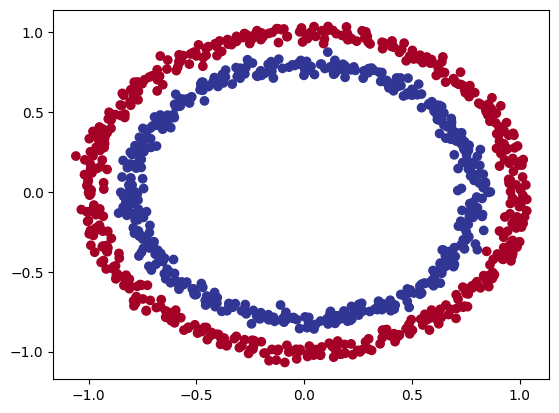

In [5]:
#Visualize Graphically
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

###Check input and Output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View first example of features and corresponing labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for a single sample of X: {X_sample} and corresponding label y: {y_sample} \n Shape of X:{X_sample.shape} and y:{y_sample.shape}")

Values for a single sample of X: [0.75424625 0.23148074] and corresponding label y: 1 
 Shape of X:(2,) and y:()


###Convert data (arrays) to tensors and create train and test split

In [8]:
import torch
torch.__version__

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype,y.dtype

(torch.float32, torch.float32)

In [9]:
#Split data into training and test sets
#Random splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Need to remember order

len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

## Building Model

We need to build a model to classify our blue and red dots.

Steps:
1. Setup device Agnostic code.
2. Construct a model( subclass nn.Module)
3. Define loss and optimization fns

In [10]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [11]:
torch.manual_seed(42)

class CircleClassificationModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=8)
    self.layer_2 = nn.Linear(in_features=8,
                             out_features=1)

  def forward(self, x: torch.Tensor):

    return self.layer_2(self.layer_1(x)) # x ->layer 1->layer 2-> returns output


#Instantiate an instance of our model class

model_0 = CircleClassificationModelV0().to(device)

next(model_0.parameters()).device


device(type='cuda', index=0)

In [12]:
torch.manual_seed(42)
#Replicate the above model with nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]],
                     device='cuda:0')),
             ('1.bias', tensor([0.2730], device='cuda:0'))])

In [13]:
#Make predictions on untrained model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 Predictions {untrained_preds[:10]}")
print(f"First 10 Labels \n {y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])
First 10 Predictions tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967],
        [-0.0059],
        [-0.4633],
        [-0.3526],
        [ 0.1179],
        [-0.4903]], device='cuda:0')
First 10 Labels 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Set up Loss function and Optimizer

In [14]:
loss_fn= nn.BCEWithLogitsLoss() #Has sigmoid activation function built-in whereas nn.BCELoss requires inputs to have gone through the sigmoid activation function before

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)


## Set up an Evaluation Metric (Accuracy)

 * Accuracy = (TP) / (TP+TN)*100

 Out of 100 examples, how many did our model guess right?


In [15]:
def accuracy_fn(y_true, y_pred):

  correct=torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100

  return acc

##Train the model


### Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be **raw logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (eg. sigmoid for binary classification and softmax for multiclass classification)

We can then convert model's prediction probabilities to prediction labels by rounding them or taking `argmax()`


In [16]:
#View first 5 outputs of the forward pass on test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device)[:5])
  y_logits

In [17]:
#Use the sigmoid activation function on our logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4230],
        [0.3825],
        [0.5294],
        [0.3937],
        [0.5242]], device='cuda:0')

In [18]:
y_preds=torch.round(y_pred_probs)

In [19]:
#All together

y_preds_labels = torch.round((torch.sigmoid(y_logits)))

#Check if equal
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


### Building Training and Testing loop

In [20]:
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 200

#Training Loop

for epoch in range(epochs):

  model_0.train()

  #Forward Pass

  y_logits = model_0(X_train).squeeze()

  y_predicted = torch.round(torch.sigmoid(y_logits))

  #Calculate loss and Accuracy(optional)

  train_loss=loss_fn(y_logits,y_train) #We use BCEwithLogitsLoss so sigmoid function is already included. raw logits expected as input.

  acc = accuracy_fn(y_true = y_train, y_pred = y_predicted)

  optimizer.zero_grad()

  train_loss.backward() #Backpropagation

  optimizer.step() #Gradient Descent


  #Testing loop


  model_0.eval()

  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  if epoch % 10 == 0:

    print(f"{epoch} Epochs || \nTrain Loss {train_loss} | Accuracy {acc} | \nTest Loss {test_loss} | Accuracy {test_acc}")








0 Epochs || 
Train Loss 0.7054367065429688 | Accuracy 48.25 | 
Test Loss 0.6948918104171753 | Accuracy 53.0
10 Epochs || 
Train Loss 0.7048197984695435 | Accuracy 48.25 | 
Test Loss 0.694431722164154 | Accuracy 53.5
20 Epochs || 
Train Loss 0.704250156879425 | Accuracy 48.375 | 
Test Loss 0.6940186619758606 | Accuracy 54.0
30 Epochs || 
Train Loss 0.7037228941917419 | Accuracy 48.25 | 
Test Loss 0.6936476230621338 | Accuracy 53.5
40 Epochs || 
Train Loss 0.7032339572906494 | Accuracy 48.0 | 
Test Loss 0.6933140158653259 | Accuracy 53.0
50 Epochs || 
Train Loss 0.7027795314788818 | Accuracy 48.0 | 
Test Loss 0.6930142045021057 | Accuracy 53.0
60 Epochs || 
Train Loss 0.7023563981056213 | Accuracy 47.875 | 
Test Loss 0.6927446126937866 | Accuracy 53.0
70 Epochs || 
Train Loss 0.7019615769386292 | Accuracy 48.25 | 
Test Loss 0.6925021409988403 | Accuracy 52.0
80 Epochs || 
Train Loss 0.7015923857688904 | Accuracy 48.25 | 
Test Loss 0.6922840476036072 | Accuracy 52.5
90 Epochs || 
Train Lo

Accuracy is about `50%` and not improving after each epoch so our model is not really doing learning. This is equivalent to just plain guessing.


Let's evaluate the model and try and figure out why

###Evaluating Model

In [21]:
#Visualize Predictions

import requests
from pathlib import Path

#Downlaod helper functions from Learn PyTorch (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists!")
else:
  print("Download help_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary




Download help_function.py


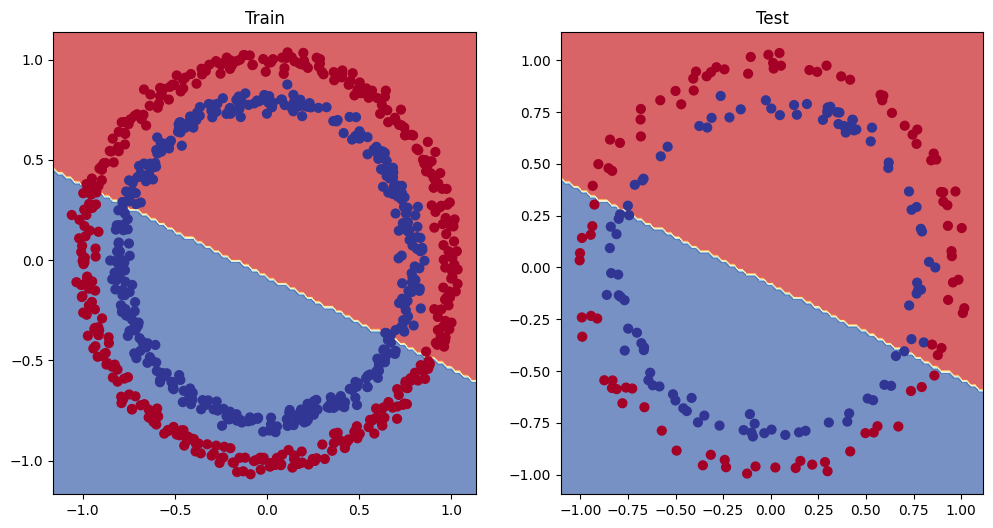

In [22]:
#Plot decision boundary of model

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1) #Number of rows and columns and index(ie. what slot will it apply to)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)


plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)



Our model is made with only **linear layers**, so this is about the best it can do to divide this circular data.

##Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about the patterns in the data
* Add more hidden units - increase `in_features` and `out_features`
* Fit for longer - Add more epochs
* Change activation functions
* Change the learning rate
* Change the loss function

Let's try and improve our model by:
* Adding more hidden units: 8 -> 16
* Increase number of layers: 2 -> 3
* Increase number of epochs: 200 -> 1000

 *Change one of them at a time to experiment*

In [23]:
class CircleClassificationModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features=16)
    self.layer2 = nn.Linear(in_features = 16, out_features = 16)
    self.layer3 = nn.Linear(in_features = 16, out_features = 1)

  def forward(self, x):

   #More readable approach
    #z = self.layer1(x)
    #z = self.layer2(z)
    #z = self.layer3(z)
    #return z
    return self.layer3(self.layer2(self.layer1(x))) #Faster approach


model_1 = CircleClassificationModelV1().to(device)
model_1


CircleClassificationModelV1(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [25]:
#Write training loop and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):

#Training Loop

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))


  loss = loss_fn(y_logits, y_train)

  accuracy = accuracy_fn(y_true = y_train,
                         y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

#Testing Loop

  model_1.eval()

  with torch.inference_mode():

    y_test_logits= model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)

    test_accuracy = accuracy_fn(y_true = y_test,
                                 y_pred = test_pred)

#Print out what's happening

    if epoch % 100 == 0:

      print(f"{epoch} Epochs ||\n Train Loss: {loss}, Accuracy: {accuracy}|\n Test Loss: {test_loss}, Accuracy: {test_accuracy}")



0 Epochs ||
 Train Loss: 0.6950545907020569, Accuracy: 46.625|
 Test Loss: 0.6988024711608887, Accuracy: 47.5
100 Epochs ||
 Train Loss: 0.6938420534133911, Accuracy: 49.625|
 Test Loss: 0.6977567672729492, Accuracy: 46.5
200 Epochs ||
 Train Loss: 0.6935340762138367, Accuracy: 49.875|
 Test Loss: 0.6973060965538025, Accuracy: 46.5
300 Epochs ||
 Train Loss: 0.6933807134628296, Accuracy: 50.625|
 Test Loss: 0.6969307065010071, Accuracy: 46.5
400 Epochs ||
 Train Loss: 0.6932768821716309, Accuracy: 50.875|
 Test Loss: 0.6966009140014648, Accuracy: 46.5
500 Epochs ||
 Train Loss: 0.6932013034820557, Accuracy: 50.875|
 Test Loss: 0.6963180303573608, Accuracy: 47.0
600 Epochs ||
 Train Loss: 0.6931452751159668, Accuracy: 50.5|
 Test Loss: 0.6960784792900085, Accuracy: 46.5
700 Epochs ||
 Train Loss: 0.6931036114692688, Accuracy: 50.625|
 Test Loss: 0.6958762407302856, Accuracy: 45.5
800 Epochs ||
 Train Loss: 0.6930725574493408, Accuracy: 50.74999999999999|
 Test Loss: 0.6957054138183594, 

Still **not** learning anything

In [26]:
#### Prepare data to see if our model is actually capable of fitting a straight line

weight = 0.7
bias = 0.5
start = 0
end = 2
step = 0.02

X_line = torch.arange(start, end, step).unsqueeze(dim = 1)
y_line = weight*X_line + bias

X_line[:5], y_line[:5], len(X_line), len(y_line)



(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.5000],
         [0.5140],
         [0.5280],
         [0.5420],
         [0.5560]]),
 100,
 100)

In [27]:
#Create train test splits

train_split = int(0.8*len(X_line))

X_reg_train, y_reg_train, X_reg_test, y_reg_test = X_line[:train_split], y_line[:train_split], X_line[train_split:], y_line[train_split:]

len(X_reg_train), len(y_reg_train), len(X_reg_test), len(y_reg_test)

(80, 80, 20, 20)

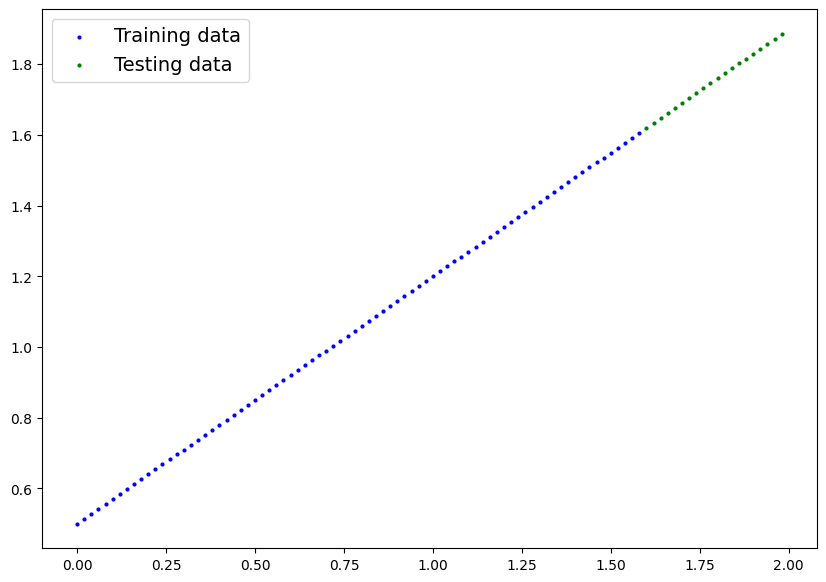

In [28]:
import helper
from helper_functions import plot_predictions
plot_predictions(train_data= X_reg_train,
                 train_labels = y_reg_train,
                 test_data = X_reg_test,
                 test_labels = y_reg_test
                 )


### Is our Model working?

In [29]:
#Same architecture as model 1 but use nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
loss_fn= nn.L1Loss()

optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_reg_train, y_reg_train, X_reg_test, y_reg_test = X_reg_train.to(device), y_reg_train.to(device), X_reg_test.to(device), y_reg_test.to(device)

#Training
for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_reg_train)

  loss = loss_fn(y_pred, y_reg_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #Testing

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_reg_test)
    test_loss = loss_fn(test_pred, y_reg_test)

    if epoch % 100 == 0 :
      print(f"{epoch} Epochs | Train Loss: {loss} | Test Loss: {test_loss}")

0 Epochs | Train Loss: 1.1132001876831055 | Test Loss: 1.4248183965682983
100 Epochs | Train Loss: 0.018911365419626236 | Test Loss: 0.06237164884805679
200 Epochs | Train Loss: 0.016255950555205345 | Test Loss: 0.0670844167470932
300 Epochs | Train Loss: 0.00385978608392179 | Test Loss: 0.08750331401824951
400 Epochs | Train Loss: 0.009995750151574612 | Test Loss: 0.07592646777629852
500 Epochs | Train Loss: 0.011180768720805645 | Test Loss: 0.07317103445529938
600 Epochs | Train Loss: 0.009920979849994183 | Test Loss: 0.07483471930027008
700 Epochs | Train Loss: 0.012439717538654804 | Test Loss: 0.06989534199237823
800 Epochs | Train Loss: 0.012900433503091335 | Test Loss: 0.06858028471469879
900 Epochs | Train Loss: 0.014962645247578621 | Test Loss: 0.06453724205493927


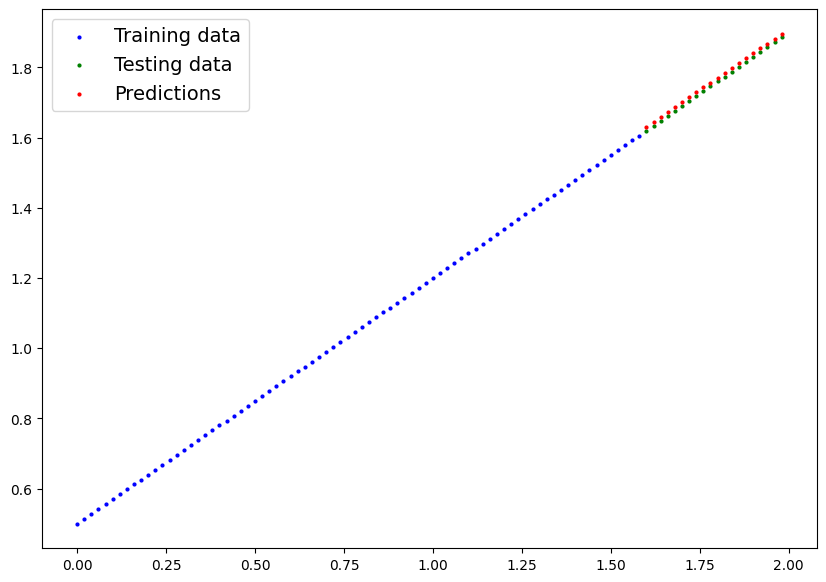

In [32]:
model_2.eval()
with torch.inference_mode():
  predictions = model_2(X_reg_test)

plot_predictions(train_data = X_reg_train.cpu(),
                 train_labels = y_reg_train.cpu(),
                 test_data = X_reg_test.cpu(),
                 test_labels = y_reg_test.cpu(),
                 predictions = test_pred.cpu())

We can see our model is actually **learning** unlike in the previous case with the circles dataset.

*Note: Earlier I had set 16 hidden units (features in hidden layer to 16) under the assumption that more units means better learning. I noticed it fits our data correctly only after `2500 epochs` as compared to 1000 epochs with 10 units.*

Our data (circles dataset) is non linear so how can we use a model with only linear layers?

##Adding non-linearity to our models

Imagine the patterns we could draw if we had both straight and curved lines

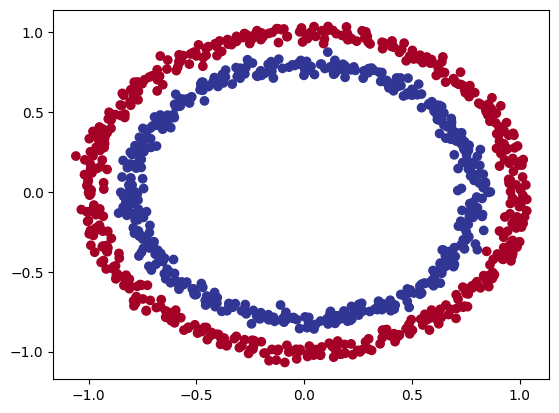

In [33]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [34]:
#Create train test split
import torch

from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building and Training a Non-Linear Model

In [35]:
from torch import nn
class CircleClassificationModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2,
                            out_features = 16)
    self.layer2 = nn.Linear(in_features = 16,
                            out_features = 16)
    self.layer3= nn.Linear(in_features = 16,
                           out_features = 1)
    self.relu = nn.ReLU() #Non-Linear activation function

  def forward(self, x):
    #Where should we put non linear activation function?
    #We can try putting it between each layer

    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleClassificationModelV2().to(device)
model_3

CircleClassificationModelV2(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [36]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)

  accuracy = accuracy_fn(y_true= y_train,
                         y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  with torch.inference_mode():

    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)


    if epoch % 100 == 0:
      print(f"{epoch} Epochs || Train Loss: {loss: .4f}, Acc:{accuracy: .2f}% || Test Loss: {loss: .4f}, Acc: {test_acc: .2f}%")


0 Epochs || Train Loss:  0.6975, Acc: 50.00% || Test Loss:  0.6975, Acc:  50.00%
100 Epochs || Train Loss:  0.6899, Acc: 56.25% || Test Loss:  0.6899, Acc:  51.50%
200 Epochs || Train Loss:  0.6866, Acc: 52.88% || Test Loss:  0.6866, Acc:  52.00%
300 Epochs || Train Loss:  0.6826, Acc: 53.62% || Test Loss:  0.6826, Acc:  52.50%
400 Epochs || Train Loss:  0.6774, Acc: 54.00% || Test Loss:  0.6774, Acc:  53.50%
500 Epochs || Train Loss:  0.6701, Acc: 56.00% || Test Loss:  0.6701, Acc:  55.50%
600 Epochs || Train Loss:  0.6594, Acc: 62.38% || Test Loss:  0.6594, Acc:  58.00%
700 Epochs || Train Loss:  0.6417, Acc: 75.50% || Test Loss:  0.6417, Acc:  68.50%
800 Epochs || Train Loss:  0.6128, Acc: 87.38% || Test Loss:  0.6128, Acc:  85.00%
900 Epochs || Train Loss:  0.5640, Acc: 97.25% || Test Loss:  0.5640, Acc:  93.00%


#### Evaluating the new trained model

In [38]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds [:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

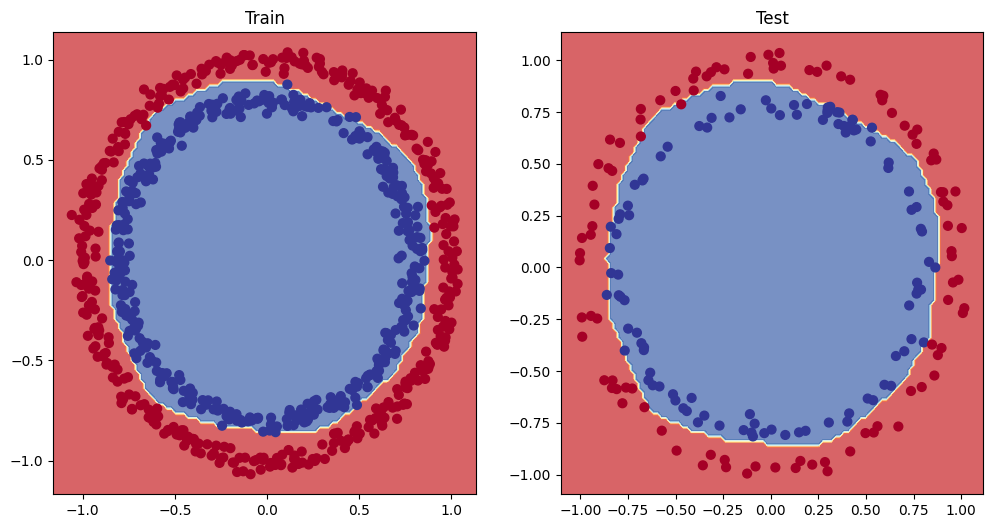

In [39]:
#Plot decision boundaries for our new model

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)



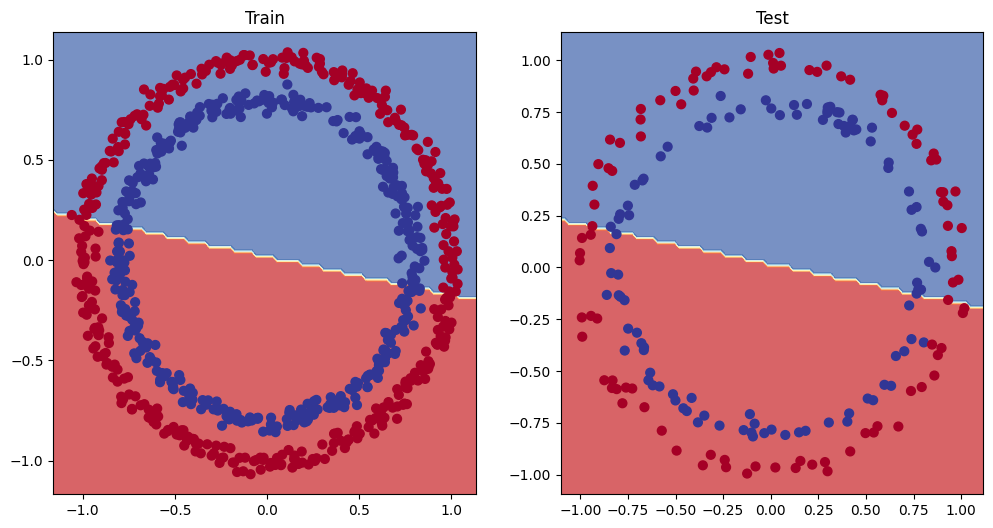

In [40]:
#Look at the old model (linear only)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)



# Replicating non-linear activation functions

In [41]:
import torch

import matplotlib.pyplot as plt

#Create a tensor
A = torch.arange(-10, 10, 1.0)



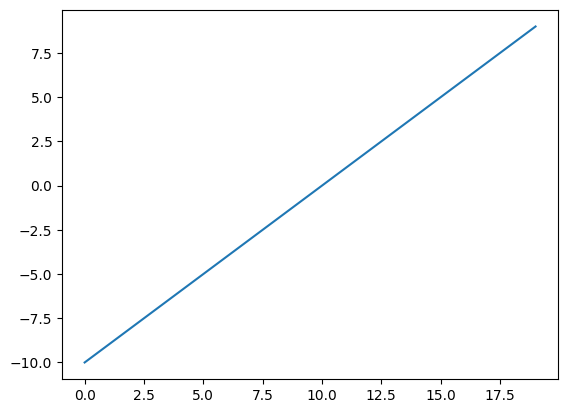

In [42]:
plt.plot(A)

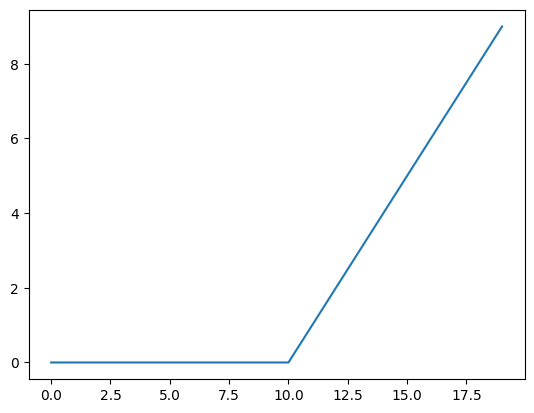

In [43]:
plt.plot(torch.relu(A))

In [44]:
#Let's code out the builtin ReLu function

def relu(x : torch.Tensor):
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

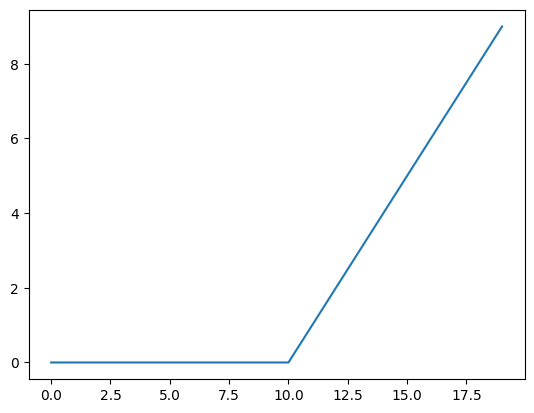

In [45]:
plt.plot(relu(A))

In [46]:
#Let's do the same for sigmoid

def sigmoid(x : torch.Tensor):
  return 1/(1 + torch.exp(-x))

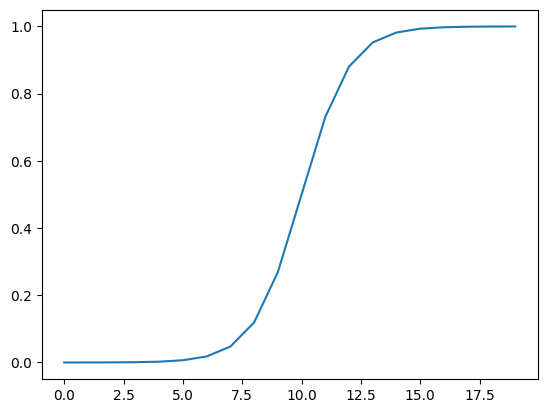

In [47]:
plt.plot(torch.sigmoid(A))

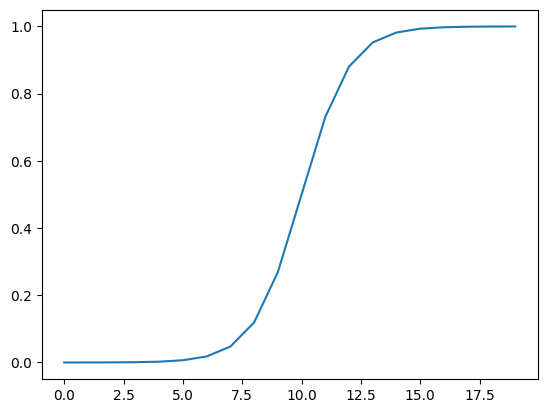

In [48]:
plt.plot(sigmoid(A))

#Multiclass Classification

##Create Datasets and Split

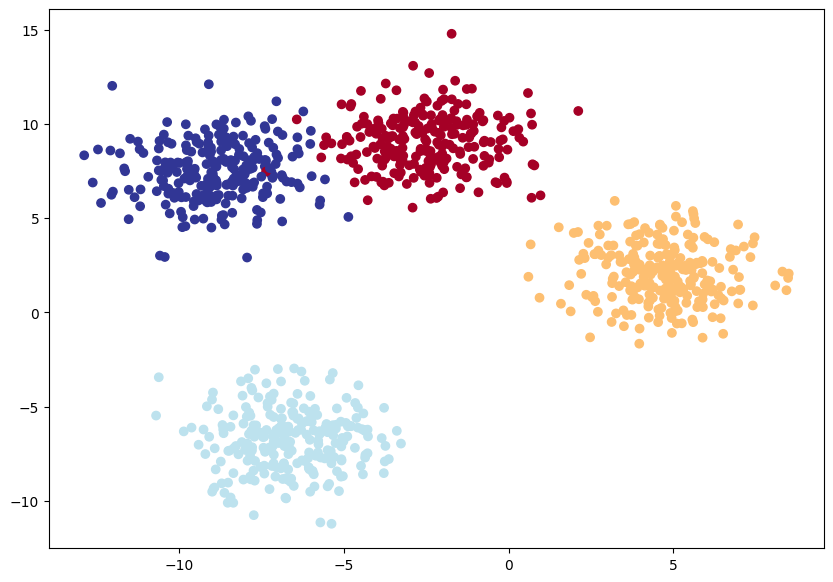

In [49]:
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set hyperparamteres for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#Create data

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers= NUM_CLASSES,
                            cluster_std = 1.5, #Standard deviation of clusters (higher value means more spread out)
                            random_state = RANDOM_SEED)

#Turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #if float will cause error in Cross Entrpy Loss

#Split into train and test

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )

#Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)





##Create Multiclass Classification Model

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

###Build Model

In [51]:
#Build the model

from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()

    self.linear_layer_stack= nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_4 = BlobModel( input_features=2, output_features=4, hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

###Set up Loss function and Optimizer

In [52]:
loss_fn = nn.CrossEntropyLoss() #There is a weight parameter you can set for an unbalanced set (ours is balanced because equal datapoints in each class)

optimizer = torch.optim.SGD(params = model_4.parameters(),
                            lr = 0.1)

### Converting raw outputs(logits) to labels

In [53]:
### Getting Prediction Probabalities for our Multiclass classification model


model_4.eval()

with torch.inference_mode():

  X_blob_test = X_blob_test.to(device)

  y_logits = model_4(X_blob_test)

y_logits[:5], y_blob_test[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0]))

In [54]:
#Convert model's logit outputs to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)

y_logits[:5], y_pred_probs[:5], y_blob_test[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0'),
 tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0]))

In [55]:
#Convert prediction probabilties to prediction labels

y_preds = torch.argmax(y_pred_probs, dim=1)

y_preds[:5]

tensor([1, 0, 0, 0, 0], device='cuda:0')

In summary, Logits --> Prediction Probabilities (use `softmax()`) --> Prediction Labels (use `argmax()`)

###Train model

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()

  with torch.inference_mode():

    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_blob_test)

    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_pred)

    if epoch%10 == 0:

      print(f"{epoch} Epochs || Train Loss {loss}, Accuracy {acc} || Test Loss {test_loss}, Accuracy: {test_acc}")








0 Epochs || Train Loss 1.1588265895843506, Accuracy 40.375 || Test Loss 1.0755419731140137, Accuracy48.0
10 Epochs || Train Loss 0.6447554230690002, Accuracy 96.75 || Test Loss 0.6606872081756592, Accuracy97.5
20 Epochs || Train Loss 0.42535150051116943, Accuracy 98.5 || Test Loss 0.43074119091033936, Accuracy100.0
30 Epochs || Train Loss 0.2529423236846924, Accuracy 99.125 || Test Loss 0.24507619440555573, Accuracy99.5
40 Epochs || Train Loss 0.11232151091098785, Accuracy 99.25 || Test Loss 0.10228516906499863, Accuracy99.5
50 Epochs || Train Loss 0.06626511365175247, Accuracy 99.25 || Test Loss 0.058475375175476074, Accuracy99.5
60 Epochs || Train Loss 0.05068015679717064, Accuracy 99.25 || Test Loss 0.042932283133268356, Accuracy99.5
70 Epochs || Train Loss 0.042996764183044434, Accuracy 99.25 || Test Loss 0.03490966185927391, Accuracy99.5
80 Epochs || Train Loss 0.038361385464668274, Accuracy 99.25 || Test Loss 0.029878225177526474, Accuracy99.5
90 Epochs || Train Loss 0.0352484323

###Evaluating our Model

In [57]:
#Make predictions and evaluate

model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred_probs = y_logits.softmax(dim = 1)
  y_pred = y_pred_probs.argmax(dim=1)



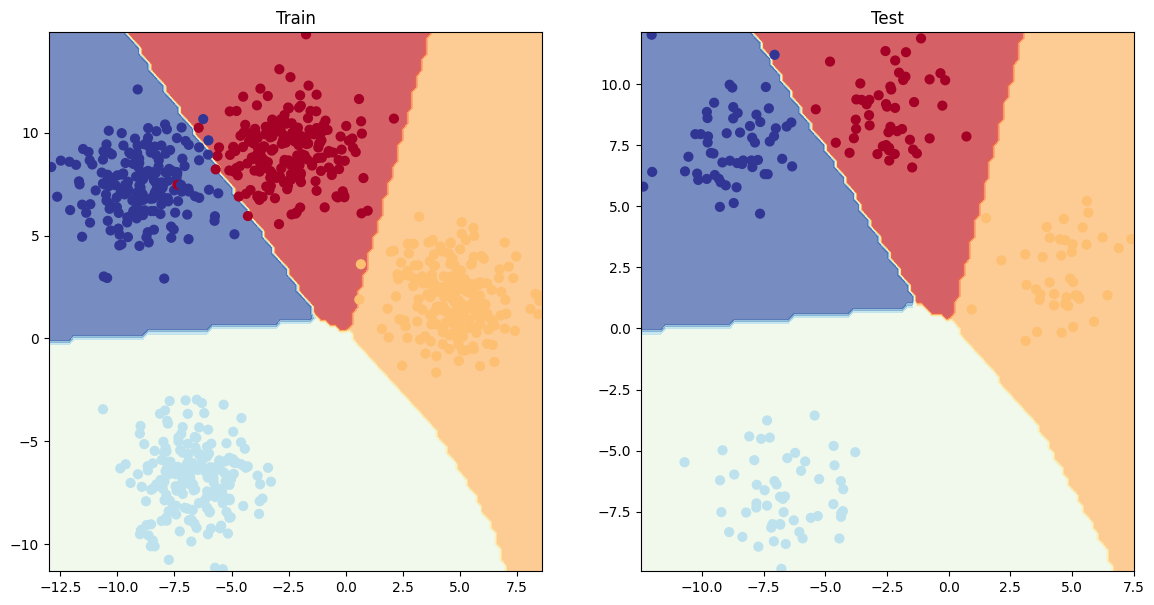

In [58]:
plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


We included non-linearity in our model but it would have still worked well with only Linear layers because our data is more or less **Linearly Separable**

#Classification Evaluation Metrics

* Accuracy
* Precision
* Recall
* F1 score
* Confusion Matrix
* Classification report


In [59]:
#Install torchmetrics

!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [61]:
from torchmetrics import Accuracy

#Setup metric

torchmetric_accuracy = Accuracy(task = 'multiclass', num_classes=4).to(device)

torchmetric_accuracy(y_pred, y_blob_test)


tensor(0.9950, device='cuda:0')

In [66]:
from torchmetrics import *

torchmetric_precision = Precision(task = 'multiclass', num_classes = 34).to(device)

torchmetric_precision(y_pred, y_blob_test)


tensor(0.9950, device='cuda:0')

In [64]:
torchmetric_recall = Recall(task = 'multiclass', num_classes = 4).to(device)

torchmetric_recall(y_pred, y_blob_test)

tensor(0.9950, device='cuda:0')